In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import pandas as pd
import random
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

In [ ]:
os.chdir('D:\Documents\MGT 6090\Assignment 9')

In [ ]:
# generate matplotlib table and output 
def df_out(df, out_file, col_labels, row_labels, dpi_val, font_size):
    plt.figure()
    # generate table
    if col_labels and row_labels:
        table = plt.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')
    elif col_labels and not row_labels:
        table = plt.table(cellText=df.values, colLabels=df.columns, loc='center')
    elif not col_labels and row_labels:
        table = plt.table(cellText=df.values, rowLabels=df.index, loc='center')
    else:
        table = plt.table(cellText=df.values, loc='center')
    table.auto_set_font_size(False)    
    table.set_fontsize(font_size)
    table.auto_set_column_width(col=list(range(len(df.columns))))
#     table.auto_set_column_width(col=len(df.columns) + 1)
    plt.axis('off')
    plt.grid('off')
    plt.tight_layout()
    # draw canvas once
    plt.gcf().canvas.draw()
    # get bounding box of table
    points = table.get_window_extent(plt.gcf()._cachedRenderer).get_points()
    # add 10 pixel spacing
    points[0,:] -= 10; points[1,:] += 10
    # get new bounding box in inches
    nbbox = matplotlib.transforms.Bbox.from_extents(points/plt.gcf().dpi)
    # save and clip by new bounding box
    plt.savefig(out_file, bbox_inches=nbbox, dpi=dpi_val)
    return

In [ ]:
gtID_seed = 902953178
np.random.seed(gtID_seed)
rand_num = np.random.randint(1, 130)
# 104
# Hilltop Holdings, Inc.

In [ ]:
# import ownership data
ownership = pd.read_excel("HTH_ownership.xlsx", sheet_name=None)

# format and output ownership breakdown table
ownership['Major Holders'].rename(columns={'Unnamed: 1' : 'Ownership'}, inplace=True)
# multiply percent values
ownership['Major Holders'].loc[0:3, 'Breakdown'] = ownership['Major Holders'].loc[0:3, 'Breakdown'] * 100
ownership['Major Holders'] = ownership['Major Holders'].reindex(columns=['Ownership', 'Breakdown'])
df_out(ownership['Major Holders'], 'major_holders.pdf', True, False, 1400, 7)

# format and output top institutional holders
ownership['Top Institutional Holders'].loc[:, '% Out'] = round(ownership['Top Institutional Holders'].loc[:, '% Out'] * 100, 2)
df_out(ownership['Top Institutional Holders'].iloc[:, [0,1,3,4]], 'top_inst_holders.pdf', True, False, 4000, 3.5)

# format and output top insider holders
ownership['Insider Roster'] = ownership['Insider Roster'].dropna()
# format date
ownership['Insider Roster'].loc[:, 'Date'] = ownership['Insider Roster'].loc[:, 'Date'].dt.date
# format names
ownership['Insider Roster'].loc[:, 'Individual or Entity'] = ownership['Insider Roster'].loc[:, 'Individual or Entity'].str.title()
df_out(ownership['Insider Roster'], 'top_insider_holders.pdf', True, False, 3000, 5)

# format and output top insider transaction info
ownership['Insider Transactions - 6 Month'].rename(columns={'Insider Purchases Last 6 Months' : 'Last 6 Months', 'Trans' : 'Transactions'}, inplace=True)
# fix nan values
ownership['Insider Transactions - 6 Month'].loc[pd.isna(ownership['Insider Transactions - 6 Month']['Transactions']), 'Transactions'] = -1
ownership['Insider Transactions - 6 Month']['Transactions'] = round(ownership['Insider Transactions - 6 Month']['Transactions']).astype(int).astype(str)
ownership['Insider Transactions - 6 Month'].loc[ownership['Insider Transactions - 6 Month']['Transactions'] == '-1', 'Transactions'] = 'N/A'
# multiply percent values
ownership['Insider Transactions - 6 Month'].loc[4, 'Shares'] = ownership['Insider Transactions - 6 Month'].loc[4, 'Shares'] * 100
df_out(ownership['Insider Transactions - 6 Month'], 'insider_last_6mo.pdf', True, False, 2100, 7)

<Figure size 432x216 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Compounded Returns')

<Figure size 432x216 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Beta')

<Figure size 432x216 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Volatility')

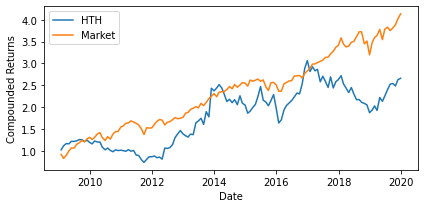

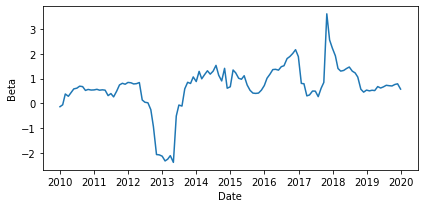

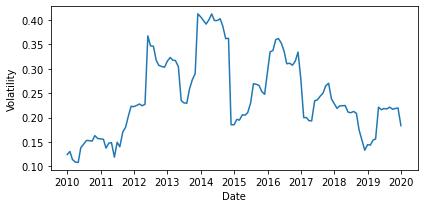

In [287]:
# import monthly return data
hth_ret = pd.read_csv("crsp_msf.csv", usecols=['DATE', 'TICKER', 'RET', 'VWRETD'], parse_dates=['DATE'], 
                  dtype={'TICKER': pd.StringDtype(), 'RET': float, 'VWRETD': float})
# filter to HTH data
hth_ret = hth_ret[hth_ret['TICKER'] == 'HTH']
# add month_year column
hth_ret['month_year'] = hth_ret['DATE'].dt.strftime("%Y%m").astype(int)

# import rf data
ff = pd.read_csv("F-F_Research_Data_Factors.csv", skiprows=4, nrows=1129, names=['month_year', 'Mkt-RF', 'SMB', 'HML', 'RF'], 
                 dtype={'month_year': int, 'Mkt-RF': float, 'SMB': float, 'HML': float, 'RF': float})
# filter to desired dates
rf = ff.loc[(ff['month_year'] >= 200901) & (ff['month_year'] <= 201912), ['month_year', 'RF']]

# join data
hth_ret = pd.merge(hth_ret, rf, how='right', on='month_year')

# calculate excess returns
hth_ret['hth_excess'] = hth_ret['RET'] - (hth_ret['RF'] / 100)
hth_ret['mkt_excess'] = hth_ret['VWRETD'] - (hth_ret['RF'] / 100)


# calculate trailing 12 month betas
betas = RollingOLS(hth_ret['hth_excess'], sm.add_constant(hth_ret['mkt_excess']), window=12).fit()
hth_ret['beta'] = betas.params['mkt_excess']

# calculate trailing 12 month annualized volatility of log returns
hth_ret['volatility'] = np.sqrt(np.log(1 + hth_ret['RET']).rolling(12).var() * 12)

# calculate compound hth and market returns over last 11 years
hth_ret['compound_hth'] = np.cumprod(1 + hth_ret['RET'])
hth_ret['compound_mkt'] = np.cumprod(1 + hth_ret['VWRETD'])


# plot returns
plt.figure(figsize=(6, 3))
plt.plot(hth_ret['DATE'], hth_ret['compound_hth'], hth_ret['DATE'], hth_ret['compound_mkt'])
plt.xlabel('Date')
plt.ylabel('Compounded Returns')
plt.legend(['HTH', 'Market'])
plt.tight_layout()
plt.savefig("returns.pdf")

# plot betas
plt.figure(figsize=(6, 3))
plt.plot(hth_ret['DATE'], hth_ret['beta'])
plt.xlabel('Date')
plt.ylabel('Beta')
plt.tight_layout()
plt.savefig("beta.pdf")

# plot volatility
plt.figure(figsize=(6, 3))
plt.plot(hth_ret['DATE'], hth_ret['volatility'])
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.tight_layout()
plt.savefig("volatility.pdf")

In [ ]:
# import short volume data
hth_short = pd.read_excel("HTH_short.xlsx", sheet_name='short')
hth_short = hth_short.iloc[:, np.r_[0:3, 5]]
# format date
hth_short['Date'] = hth_short['Date'].dt.date
# write to pdf
df_out(hth_short, 'short.pdf', True, False, 1200, 7)

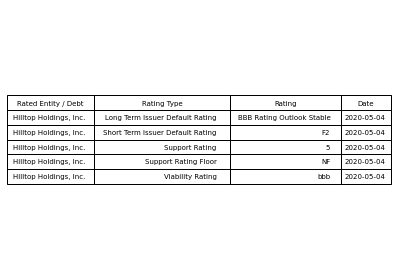

In [290]:
# import fitch ratings
hth_fitch = pd.read_excel("hth_fitch.xlsx", usecols=['RATED ENTITY / DEBT', 'RATING TYPE', 'RATING', 'DATE'], parse_dates=['DATE'],
                         dtype={'RATED ENTITY / DEBT': pd.StringDtype(), 'RATING TYPE' : pd.StringDtype(), 'RATING': pd.StringDtype()})
hth_fitch['DATE'] = hth_fitch['DATE'].dt.date
# change column capitalization
hth_fitch.columns = [x.title() for x in hth_fitch.columns]
df_out(hth_fitch, 'hth_fitch.pdf', True, False, 1200, 7)

In [ ]:
# import analyst ratings
hth_analyst = pd.read_excel("hth_analyst.xlsx", usecols=['Date', 'Brokerage', 'Action', 'Rating', 'Price Target'], parse_dates=['Date'],
                           dtype={'Brokerage': pd.StringDtype(), 'Action': pd.StringDtype(), 'Rating': pd.StringDtype(), 'Price Target': pd.StringDtype()})
# format date
hth_analyst['Date'] = hth_analyst['Date'].dt.date
df_out(hth_analyst, 'hth_analyst.pdf', True, False, 1200, 7)

In [ ]:
# import bhc performance report data
bhc = pd.read_csv("BHCPR_3838727_20191231.csv", usecols=['ItemName', 'Description', 'Value'],
                 dtype=pd.StringDtype())

In [ ]:
def get_bhc_val(bhc, val_type, descript):
    if val_type == 'Peer Group':
        new_descript = 'PG RATIO: ' + descript
    elif val_type == 'Percentile':
        new_descript = 'PG RANK: ' + descript
    else:
        new_descript = descript
    # get value with given description as float, reverse list so data is in chronological order
    vals = bhc.loc[bhc['Description'] == new_descript, 'Value'].astype(float).tolist()
    vals.reverse()
    return vals
    
def get_bhc_vals(bhc, incl_pg, incl_pct, descript):
    vals = []
    vals.append(['HTH'] + get_bhc_val(bhc, 'HTH', descript))
    if incl_pg:
        vals.append(['Peer Group'] + get_bhc_val(bhc, 'Peer Group', descript))
    if incl_pct:
        vals.append(['Percentile'] + get_bhc_val(bhc, 'Percentile', descript))
    return vals

In [288]:
# earnings as percent of average assets
earnings = get_bhc_vals(bhc, True, True, 'NET INCOME / AVERAGE ASSETS')

# net interest margins as percent of average earning assets
net_interest_margins = get_bhc_vals(bhc, True, True, 'NET INTEREST INCOME (TE) / AVERAGE EARNED ASSETS')

# non interest income as percent of average assets
non_interest_income = get_bhc_vals(bhc, True, True, 'NON-INTEREST INCOME / AVERAGE ASSETS')

# revenue as percent of average assets
revenue = []
revenue.append(['Revenue'] + 
               np.round(np.array(get_bhc_val(bhc, 'HTH', 'INTEREST INCOME (TE) / AVERAGE ASSETS')) + 
                        np.array(get_bhc_val(bhc, 'HTH', 'NON-INTEREST INCOME / AVERAGE ASSETS')), 2).tolist())

# expenses as percent of average assets
expenses = []
expenses.append(['Expenses'] + 
                np.round(np.array(revenue[0][1:6]) - 
                         np.array(earnings[0][1:6]), 2).tolist())

# loans as percent of gross loans and leases
loans = [['Real Estate'] + get_bhc_val(bhc, 'HTH', 'REAL ESTATE LOANS / GROSS LOANS AND LEASES'),
         ['Depository Institutions'] + get_bhc_val(bhc, 'HTH', 'LOANS TO DEPOSITORY INSTITUTIONS / GROSS LOANS AND LEASES'), 
         ['Commercial and Industrial'] + get_bhc_val(bhc, 'HTH', 'COMMERCIAL & INDUSTRIAL LOANS / GROSS LOANS AND LEASES'),
         ['Individuals'] + get_bhc_val(bhc, 'HTH', 'LOANS TO INDIVIDUALS / GROSS LOANS AND LEASES'),
         ['Agricultural'] + get_bhc_val(bhc, 'HTH', 'AGRICULTURAL LOANS / GROSS LOANS & LEASES'),
         ['Other'] + get_bhc_val(bhc, 'HTH', 'OTHER LOANS AND LEASES / GROSS LOANS AND LEASES')]

# net loan/lease loss over average loan/lease
loan_loss = get_bhc_vals(bhc, True, True, 'NET LOAN & LEASE LOSSES / AVERAGE LOANS & LEASES')

# past due loans/leases as percent of loans/leases
past_due = [['30-89 Days Past Due'] + get_bhc_val(bhc, 'HTH', 'TOTAL 30-89 DAYS PAST DUE / TOTAL LOANS & LEASES (CONFIDENTIAL PRIOR TO MARCH 2001)'),
            ['90+ Days Past Due'] + get_bhc_val(bhc, 'HTH', '90+ DAYS PAST DUE ASSETS / TOTAL LOANS AND LEASES'),
            ['Nonaccrual'] + get_bhc_val(bhc, 'HTH', 'NONACCRUAL ASSETS / TOTAL LOANS AND LEASES')]


# loan loss reserves / total loans/leases
reserves = get_bhc_vals(bhc, True, True, 'ALLOWANCE FOR LOAN & LEASE LOSSES / TOTAL LOANS & LEASES')

# liquidity and funding as percent of total assets
liquidity = [['Short-Term Investments'] + get_bhc_val(bhc, 'HTH', 'SHORT-TERM INVESTMENTS / CONSOLIDATED ASSETS'),
             ['Liquid Assets'] + get_bhc_val(bhc, 'HTH', 'LIQUID ASSETS / TOTAL ASSETS'),
             ['Investment Securities'] + get_bhc_val(bhc, 'HTH', 'INVESTMENT SECURITIES / CONSOLIDATED ASSETS'),
             ['Net Loans and Leases'] + get_bhc_val(bhc, 'HTH', 'NET LOANS AND LEASES / TOTAL ASSETS'),
             ['Core Deposits'] + get_bhc_val(bhc, 'HTH', 'CORE DEPOSITS / TOTAL ASSETS'),
             ['Noncore Funding'] + get_bhc_val(bhc, 'HTH', 'NONCORE FUNDING / TOTAL ASSETS'),
             ['Time Deposits of $250K or More'] + [np.nan, np.nan] + get_bhc_val(bhc, 'HTH', 'TIME DEPOSITS OF $250K OR MORE / TOTAL ASSETS'),
             ['Foreign Deposits'] + get_bhc_val(bhc, 'HTH', 'FOREIGN DEPOSITS / CONSOLIDATED ASSETS'),
             ['Federal Funds Purchased and Repos'] + get_bhc_val(bhc, 'HTH', 'FEDERAL FUNDS PURCHASED & REPOS / CONSOLIDATED ASSETS')]

# capitalization ratios
capitalization = [['Tier 1 Leverage Ratio'] + get_bhc_val(bhc, 'HTH', 'TIER 1 LEVERAGE RATIO')[3:8],
                  ['Holding Company Equity Capital / Total Assets'] + get_bhc_val(bhc, 'HTH', 'TOTAL EQUITY CAPITAL / TOTAL ASSETS'),
                  ['Total Equity Capital Including Minority Interest / Total Assets'] + get_bhc_val(bhc, 'HTH', 'EQUITY CAP & NONCONTROL (MINORITY) INTEREST / T. ASSETS'),
                  ['Common Equity Tier 1 Capital / Total Risk-Weighted Assets'] + get_bhc_val(bhc, 'HTH', 'TIER 1 COMMON EQUITY TO RISK WEIGHTED ASSETS'),
                  ['Net Loans and Leases / Equity Capital (X)'] + get_bhc_val(bhc, 'HTH', 'NET LOANS AND LEASES / TOTAL EQUITY CAPITAL (X)'),
                  ['Cash Dividends / Net Income'] + get_bhc_val(bhc, 'HTH', 'DIVIDENDS / NET INCOME')]

# 12 month growth rates
growth_rates = [['Assets'] + get_bhc_val(bhc, 'HTH', 'PERCENT CHANGE: TOTAL ASSETS'),
                ['Equity Capital'] + get_bhc_val(bhc, 'HTH', 'EQUITY CAPITAL GROWTH RATE'),
                ['Net Loans and Leases'] + get_bhc_val(bhc, 'HTH', 'PERCENT CHANGE: NET LOANS AND LEASES'),
                ['Noncore Funding'] + get_bhc_val(bhc, 'HTH', 'PERCENT CHANGE: NONCORE FUNDING')]

# percent composition of assets
asset_comp = [['Real Estate Loans'] + get_bhc_val(bhc, 'HTH', 'REAL ESTATE LOANS / CONSOLIDATED ASSETS'),
              ['Commercial and Industrial Loans'] + get_bhc_val(bhc, 'HTH', 'COMMERCIAL AND INDUSTRIAL LOANS / CONSOLIDATED ASSETS'),
              ['Loans to Individuals'] + get_bhc_val(bhc, 'HTH', 'LOANS TO INDIVIDUALS / CONSOLIDATED ASSETS'),
              ['Loans to Depository Institutions'] + get_bhc_val(bhc, 'HTH', 'LOANS TO DEPOSITORY INSTITUTIONS / CONSOLIDATED ASSETS'),
              ['Agricultural Loans'] + get_bhc_val(bhc, 'HTH', 'AGRICULTURAL LOANS / CONSOLIDATED ASSETS'),
              ['Other Loans and Leases'] + get_bhc_val(bhc, 'HTH', 'OTHER LOANS AND LEASES / CONSOLIDATED ASSETS'),
              ['Debt Securities Over 1 Year'] + get_bhc_val(bhc, 'HTH', 'SECURITIES OVER 1 YEAR / CONSOLIDATED ASSETS'),
              ['Mutual Funds and Equity Securities'] + get_bhc_val(bhc, 'HTH', 'MUTUAL FUNDS AND EQUITY SECURITIES / CONSOLIDATED ASSETS'),
              ['Interest-Bearing Bank Balances'] + get_bhc_val(bhc, 'HTH', 'INTEREST-BEARING BANK BALANCES / CONSOLIDATED ASSETS'),
              ['Federal Funds Sold and Reverse Repos'] + get_bhc_val(bhc, 'HTH', 'FEDERAL FUNDS SOLD AND REVERSE REPOS / CONSOLIDATED ASSETS'),
              ['Debt Securities 1 Year or Less'] + get_bhc_val(bhc, 'HTH', 'DEBT SECURITIES 1 YR OR LESS / CONSOLIDATED ASSETS'),
              ['Trading Assets'] + get_bhc_val(bhc, 'HTH', 'TRADING ACCOUNT ASSETS / CONSOLIDATED ASSETS'),
              ['Non-Interest Cash and Due from Depository Insitutions'] + get_bhc_val(bhc, 'HTH', 'NON-INTEREST-BEARING CASH & DUE FROM BANKS / CONSOLIDATED ASSETS'),
              ['Other Real Estate Owned'] + get_bhc_val(bhc, 'HTH', 'OTHER REAL ESTATE OWNED / CONSOLIDATED ASSETS'),
              ['All Other Assets'] + get_bhc_val(bhc, 'HTH', 'ALL OTHER ASSETS / CONSOLIDATED ASSETS')]

# get total liabilities over 100 to pre-emptively convert to percents
total_liabilities = np.array(get_bhc_val(bhc, 'HTH', 'TOTAL LIABILITIES')[5:10]) / 100
# calculate percent composition of liabilities
liability_comp = [['Demand Deposits'] + np.divide(np.array(get_bhc_val(bhc, 'HTH', 'NONINTEREST-BEARING BALANCES (BHC CONSOL. COMML. BANKS)')), total_liabilities).tolist(),
                  ['NOW, ATS, and Transaction Accounts'] + np.divide(np.array(get_bhc_val(bhc, 'HTH', 'NOW, ATS AND TRANSACTION ACCOUNTS')), total_liabilities).tolist(),
                  ['Time Deposits Less Brokered Deposits < $250K'] + np.divide(np.array([np.nan, np.nan] + get_bhc_val(bhc, 'HTH', 'TIME DEPOSITS (EXCLUDING BROKERED DEPOSITS) < $250K')), total_liabilities).tolist(),
                  ['MMDA and Other Savings Accounts'] + np.divide(np.array(get_bhc_val(bhc, 'HTH', 'MMDA & OTHER SAVINGS ACCOUNTS')), total_liabilities).tolist(),
                  ['Time Deposits of $250K or More'] + np.divide(np.array([np.nan, np.nan] + get_bhc_val(bhc, 'HTH', 'TIME DEPOSITS OF $250K OR MORE')[0:3]), total_liabilities).tolist(),
                  ['Foreign Deposits'] + np.divide(np.array(get_bhc_val(bhc, 'HTH', 'FOREIGN DEPOSITS')), total_liabilities).tolist(),
                  ['Federal Funds Purchased and Repos'] + np.divide(np.array(get_bhc_val(bhc, 'HTH', 'FEDERAL FUNDS PURCHASED AND SECURITIES SOLD (REPOS)')), total_liabilities).tolist(),
                  ['Other Borrowings with Remaining Maturity 1 Year Or Less'] + np.divide(np.array(get_bhc_val(bhc, 'HTH', 'OTHER BORROWED MONEY WITH A REMAINING MATURITY OF 1 YR OR LESS (BHC CONSOLIDATED)')), total_liabilities).tolist(),
                  ['Other Borrowings with Remaining Maturity Over 1 Year'] + np.divide(np.array(get_bhc_val(bhc, 'HTH', 'OTHER BORROWED MONEY WITH A REMAINING MATURITY OF MORE THAN ONE YEAR')), total_liabilities).tolist(),
                  ['Brokered Deposits < $250K'] + np.divide(np.array([np.nan, np.nan] + get_bhc_val(bhc, 'HTH', 'BROKERED DEPOSITS < $250K')), total_liabilities).tolist(),
                  ['Trading Liabilities'] + np.divide(np.array(get_bhc_val(bhc, 'HTH', 'TRADING LIABILITIES')), total_liabilities).tolist(),
                  ['Subordinated Notes and Debentures and Trust Preferred Securities'] + np.divide(np.array(get_bhc_val(bhc, 'HTH', 'SUBORDINATED NOTES AND DEBENTURES (CONSOLIDATED)')), total_liabilities).tolist(),
                  ['Other Liabilities'] + np.divide(np.array(get_bhc_val(bhc, 'HTH', 'OTHER LIAB.')), total_liabilities).tolist()]


In [304]:
capitalization_percent = [['Tier 1 Leverage Ratio'] + get_bhc_val(bhc, 'Percentile', 'TIER 1 LEVERAGE RATIO')[3:8],
                          ['Holding Company Equity Capital / Total Assets'] + get_bhc_val(bhc, 'Percentile', 'TOTAL EQUITY CAPITAL / TOTAL ASSETS'),
                          ['Total Equity Capital Including Minority Interest / Total Assets'] + get_bhc_val(bhc, 'Percentile', 'EQUITY CAP & NONCONTROL (MINORITY) INTEREST / T. ASSETS'),
                          ['Common Equity Tier 1 Capital / Total Risk-Weighted Assets'] + get_bhc_val(bhc, 'Percentile', 'TIER 1 COMMON EQUITY TO RISK WEIGHTED ASSETS'),
                          ['Net Loans and Leases / Equity Capital (X)'] + get_bhc_val(bhc, 'Percentile', 'NET LOANS AND LEASES / TOTAL EQUITY CAPITAL (X)'),
                          ['Cash Dividends / Net Income'] + get_bhc_val(bhc, 'Percentile', 'DIVIDENDS / NET INCOME')]

growth_rates_percent = [['Assets'] + get_bhc_val(bhc, 'Percentile', 'PERCENT CHANGE: TOTAL ASSETS'),
                        ['Equity Capital'] + get_bhc_val(bhc, 'Percentile', 'EQUITY CAPITAL GROWTH RATE'),
                        ['Net Loans and Leases'] + get_bhc_val(bhc, 'Percentile', 'PERCENT CHANGE: NET LOANS AND LEASES'),
                        ['Noncore Funding'] + get_bhc_val(bhc, 'Percentile', 'PERCENT CHANGE: NONCORE FUNDING')]


[['Tier 1 Leverage Ratio', 91.0, 95.0, 94.0, 94.0, 93.0],
 ['Holding Company Equity Capital / Total Assets',
  90.0,
  88.0,
  80.0,
  77.0,
  68.0],
 ['Total Equity Capital Including Minority Interest / Total Assets',
  88.0,
  88.0,
  80.0,
  78.0,
  69.0],
 ['Common Equity Tier 1 Capital / Total Risk-Weighted Assets',
  92.0,
  96.0,
  93.0,
  88.0,
  91.0],
 ['Net Loans and Leases / Equity Capital (X)', 21.0, 23.0, 24.0, 26.0, 33.0],
 ['Cash Dividends / Net Income', 16.0, 14.0, 24.0, 30.0, 17.0]]

[['Assets', 93.0, 60.0, 50.0, 29.0, 69.0],
 ['Equity Capital', 91.0, 63.0, 25.0, 30.0, 52.0],
 ['Net Loans and Leases', 87.0, 70.0, 29.0, 22.0, 77.0],
 ['Noncore Funding', 57.0, 70.0, 27.0, 12.0, 86.0]]

In [295]:
# plot dataframe with one or two subplots
def plot_df(df, legend_on, num_plots, plot1_num_lines, y_name, out_file, fig_size=(5,5), 
            legend_loc=None, legend_bbox=None, legend_ncol=1):
    plt.figure()
    df_cols = df.columns.tolist()
    if num_plots == 1:
        # if one plot initialize ax1
        fig, ax1 = plt.subplots(figsize=fig_size)
    if num_plots == 2:
        # if two plots intialize ax1, ax2 and set ax2 values
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
        ax2.plot('Years', 'Percentile', 'g-', data=df)
        ax2.set_ylim(0, 100)
        ax2.set_xlabel('Fiscal Year')
        ax2.set_ylabel('HTH Percentile')
    
    # plot all other vals, increment df_cols by one because of years column
    for i in range(plot1_num_lines):
        ax1.plot('Years', df_cols[i+1], data=df)
    # set ax1 values
    ax1.set_xlabel('Fiscal Year')
    ax1.set_ylabel(y_name)
    if legend_on:
        if legend_loc is None and legend_bbox is None:
            ax1.legend()
        else:
            ax1.legend(bbox_to_anchor=legend_bbox, loc = legend_loc, ncol=legend_ncol)
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()
    return

# turn list of lists into dataframe, add years, transpose and format
def list2d_to_df(list_2d):
    years_list = ['Years', '2015', '2016', '2017', '2018', '2019']
    df = pd.DataFrame([years_list] + list_2d).T
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    return df

In [306]:
# use above helper functions to plot all values
plot_df(list2d_to_df(earnings), True, 2, 2, 'Earnings', 'earnings.pdf', fig_size=(11, 3))
plot_df(list2d_to_df(net_interest_margins), True, 2, 2, 'Net Interest Margins', 'net_interest_margins.pdf', fig_size=(11, 3))
plot_df(list2d_to_df(non_interest_income), True, 2, 2, 'Non-Interest Income', 'non_interest_income.pdf', fig_size=(11, 3))
plot_df(list2d_to_df(revenue + expenses), True, 1, 2, 'Percent of Average Assets', 'revenue_expenses.pdf', fig_size=(6, 3))
# plot_df(list2d_to_df(expenses), False, 1, 1, 'Expenses', 'expenses.pdf')
plot_df(list2d_to_df(loans), True, 1, len(loans), 'Percent of Gross Loans and Leases', 'loan_mix.pdf', 
        legend_loc='upper left', legend_bbox=(1.04, 1), fig_size=(10, 3))
plot_df(list2d_to_df(loan_loss), True, 2, 2, 'Net Loan and Lease Losses', 'loan_loss.pdf', fig_size=(11, 3))
plot_df(list2d_to_df(past_due), True, 1, len(past_due), 'Percent of Loans and Leases', 'past_due.pdf', 
        legend_loc='upper left', legend_bbox=(1.04, 1), fig_size=(10, 3))
plot_df(list2d_to_df(reserves), True, 2, 2, 'Allowance for Loan and Lease Losses', 'loan_reserves.pdf', fig_size=(11, 3))
plot_df(list2d_to_df(liquidity), True, 1, len(liquidity), 'Percent of Total Assets', 'liquidity_funding.pdf', 
        legend_loc='upper left', legend_bbox=(1.04, 1), fig_size=(10, 4))
plot_df(list2d_to_df(capitalization), True, 1, len(capitalization), 'Capitalization Ratio', 'capitalization_ratios.pdf', 
        legend_loc='upper left', legend_bbox=(1.04, 1), fig_size=(11, 3))
plot_df(list2d_to_df(capitalization_percent), True, 1, len(capitalization_percent), 'HTH Percentile vs Peer Group', 'capitalization_ratios_percent.pdf', 
        legend_loc='upper left', legend_bbox=(1.04, 1), fig_size=(11, 3))
plot_df(list2d_to_df(growth_rates), True, 1, len(growth_rates), 'Growth Rate', 'growth_rates.pdf', 
        legend_loc='upper left', legend_bbox=(1.04, 1), fig_size=(11, 3))
plot_df(list2d_to_df(growth_rates_percent), True, 1, len(growth_rates_percent), 'HTH Percentile vs Peer Group', 'growth_rates_percent.pdf', 
        legend_loc='upper left', legend_bbox=(1.04, 1), fig_size=(11, 3))
plot_df(list2d_to_df(asset_comp), True, 1, len(asset_comp), 'Percent of Total Assets', 'asset_composition.pdf', 
        legend_loc='upper center', legend_bbox=(0.5, -0.075), legend_ncol=3, fig_size=(15, 8))
plot_df(list2d_to_df(liability_comp), True, 1, len(liability_comp), 'Percent of Total Liabilities', 'liability_composition.pdf', 
        legend_loc='upper center', legend_bbox=(0.5, -0.075), legend_ncol=3, fig_size=(15, 8))


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>